In [2]:
import gc
import os
import sys
import math
import random
import warnings
import pickle
from pathlib import Path
from joblib import Parallel, delayed
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

from tqdm import tqdm
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from pandarallel import pandarallel
# pandarallel.initialize()
warnings.simplefilter("ignore")
import ctypes as ct
from datetime import timedelta

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PowerTransformer

import lightgbm as lgbm


In [3]:
sys.path.append('../../')
import src.utils as utils

In [4]:
EXP_NUM = 1

In [5]:
DATA_DIR = Path("/home/knikaido/work/MLB-Player-Digital-Engagement-Forecasting/data/")
MAIN_DATA_DIR = DATA_DIR / 'mlb-player-digital-engagement-forecasting'
TRAIN_DIR = MAIN_DATA_DIR / 'train'
OUTPUT_DIR = Path('./output/')

In [6]:
players = pd.read_csv(MAIN_DATA_DIR / 'players.csv')

rosters = pd.read_csv(TRAIN_DIR / 'rosters_train.csv')
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')
scores = pd.read_csv(TRAIN_DIR / 'playerBoxScores_train.csv')
scores['gameday'] = 1
scores = scores.groupby(['playerId', 'date']).sum().reset_index()
seasons = pd.read_csv(MAIN_DATA_DIR / 'seasons.csv')


In [7]:
seasons = seasons.fillna('1970-01-01')
for c_ in seasons.columns[1:]:
    seasons[c_] = pd.to_datetime(seasons[c_].str.replace('-', '').astype(int), format="%Y%m%d")

In [8]:
seasons

,seasonId,seasonStartDate,seasonEndDate,preSeasonStartDate,preSeasonEndDate,regularSeasonStartDate,regularSeasonEndDate,lastDate1stHalf,allStarDate,firstDate2ndHalf,postSeasonStartDate,postSeasonEndDate
0,2017,2017-04-02,2017-11-01,2017-02-22,2017-04-01,2017-04-02,2017-10-01,2017-07-09,2017-07-11,2017-07-14,2017-10-03,2017-11-01
1,2018,2018-03-29,2018-10-28,2018-02-21,2018-03-27,2018-03-29,2018-10-01,2018-07-15,2018-07-17,2018-07-19,2018-10-02,2018-10-28
2,2019,2019-03-20,2019-10-30,2019-02-21,2019-03-26,2019-03-20,2019-09-29,2019-07-07,2019-07-09,2019-07-11,2019-10-01,2019-10-30
3,2020,2020-07-23,2020-10-28,2020-02-21,2020-07-22,2020-07-23,2020-09-27,2020-08-25,1970-01-01,2020-08-26,2020-09-29,2020-10-28
4,2021,2021-02-28,2021-10-31,2021-02-28,2021-03-30,2021-04-01,2021-10-03,2021-07-11,2021-07-13,2021-07-15,2021-10-04,2021-10-31


In [9]:
player_target_stats = pd.read_csv(MAIN_DATA_DIR / "player_target_stats.csv")

In [10]:
scores[scores['date']>= 20200101]

,playerId,date,home,gamePk,teamId,jerseyNum,positionCode,battingOrder,gamesPlayedBatting,flyOuts,...,sacFliesPitching,saves,holds,blownSaves,assists,putOuts,errors,chances,index,gameday
715,405395,20200724,0,631182,108,5.0,3,600.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,935,1
716,405395,20200725,0,631181,108,5.0,3,400.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,6.0,936,1
717,405395,20200727,0,631168,108,5.0,3,600.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,938,1
718,405395,20200728,1,631387,108,5.0,3,600.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,8.0,0.0,9.0,939,1
719,405395,20200730,1,631390,108,5.0,3,600.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.0,0.0,7.0,941,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182945,685503,20210409,1,634478,140,35.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1194,1
182946,685503,20210414,0,634496,140,35.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1199,1
182947,685503,20210419,0,634536,140,35.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1204,1
182948,685503,20210425,0,634393,140,35.0,1,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1210,1


(17619.0, 18747.0)

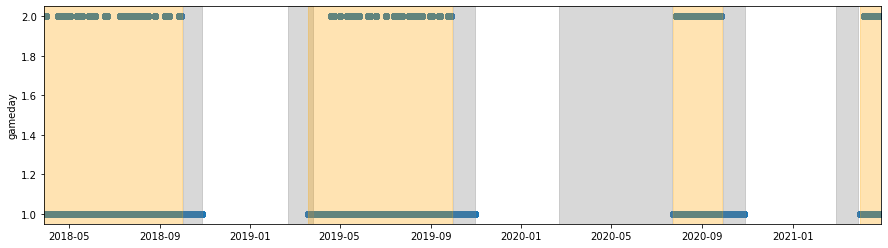

In [17]:
plt.figure(figsize=(15, 4))
for i in range(len(seasons)):
    plt.axvspan(seasons['preSeasonStartDate'][i], seasons['preSeasonEndDate'][i], color="gray", alpha=0.3)
for i in range(len(seasons)):
    plt.axvspan(seasons['regularSeasonStartDate'][i], seasons['regularSeasonEndDate'][i], color="orange", alpha=0.3)
for i in range(len(seasons)):
    plt.axvspan(seasons['postSeasonStartDate'][i], seasons['postSeasonEndDate'][i], color="gray", alpha=0.3)
dates = pd.to_datetime(scores['date'], format="%Y%m%d").values
plt.scatter(dates, scores['gameday'].values)
plt.ylabel('gameday')
plt.xlim(np.min(dates), np.max(dates))
# plt.legend()
# plt.show()

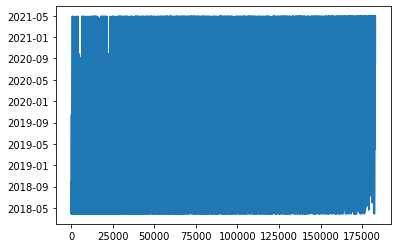

In [26]:
plt.plot(dates)